# SARIMA model for County 0JTMM
### Strategy
- The model should be fit to data for a single county (or a type of county if appropriate, e.g. rural)
- Use multiple years worth of data for that county and store the number of calls each day as our timeseries data
- Investigate PACF and ACF graphs to identify reasonable parameters (p,d,q)(P,D,Q)m
- Fit SARIMA model on training data (decide how large hold out set should be)
- Compare MSE of our custom model to baseline model (naive forecast?) and the auto ARIMA model (goal: find something that outperforms baseline)
- Use best model to predict future call volume
- Option: stratify data for the county by call type, as the call types may have different seasonality

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import set_style
set_style=("whitegrid")

In [ ]:
#create dataframe from county 0JTMM, 2018-2021
#the csv files have all data in a single column, so we need to separate them using the delimiter
L=[]
for i in range(2018,2022): #adjust here when we get more years of data
    L.append(pd.read_csv('data/pub_data_'+str(i)+'.csv',header=None, delimiter="|"))

df=pd.concat(L, ignore_index=True)

#properly label columns
df=df.rename(columns={0:'PcrKey',1:'eTimes_03',2:'eDispatch_01'})

#create DateTime column
df['DateTime']=pd.to_datetime(df['eTimes_03'],exact=False, errors='coerce')

#format='%Y-%m-%d %H:%M:%S'

#after 2019, switches datetime format, so need to fix the NaT errors
df.loc[df.DateTime.isna(),'DateTime']=pd.to_datetime(df.loc[df.DateTime.isna(),'eTimes_03'], format='%d%b%Y:%H:%M:%S',exact=False, errors='coerce')


#create Date column (only date without time)
df['Date']=df.DateTime.apply(lambda x : x.date())

df.head()

,PcrKey,eTimes_03,eDispatch_01,DateTime,Date
0,12184998.0,2018-01-12 23:20:00,2301071,2018-01-12 23:20:00,2018-01-12
1,12185016.0,2018-02-10 06:47:00,2301071,2018-02-10 06:47:00,2018-02-10
2,12185120.0,2018-02-21 14:26:00,2301071,2018-02-21 14:26:00,2018-02-21
3,12185515.0,2018-03-29 12:20:00,2301071,2018-03-29 12:20:00,2018-03-29
4,12185974.0,2018-01-15 01:50:00,2301071,2018-01-15 01:50:00,2018-01-15


In [ ]:
#create data: stores the number of calls each day
data=df.Date.value_counts().sort_index().reset_index().rename(columns={'index':'Value','Date':'date'})

data

,date,count
0,2018-01-01,11
1,2018-01-02,17
2,2018-01-03,17
3,2018-01-04,15
4,2018-01-05,19
...,...,...
1456,2021-12-27,71
1457,2021-12-28,94
1458,2021-12-29,70
1459,2021-12-30,89


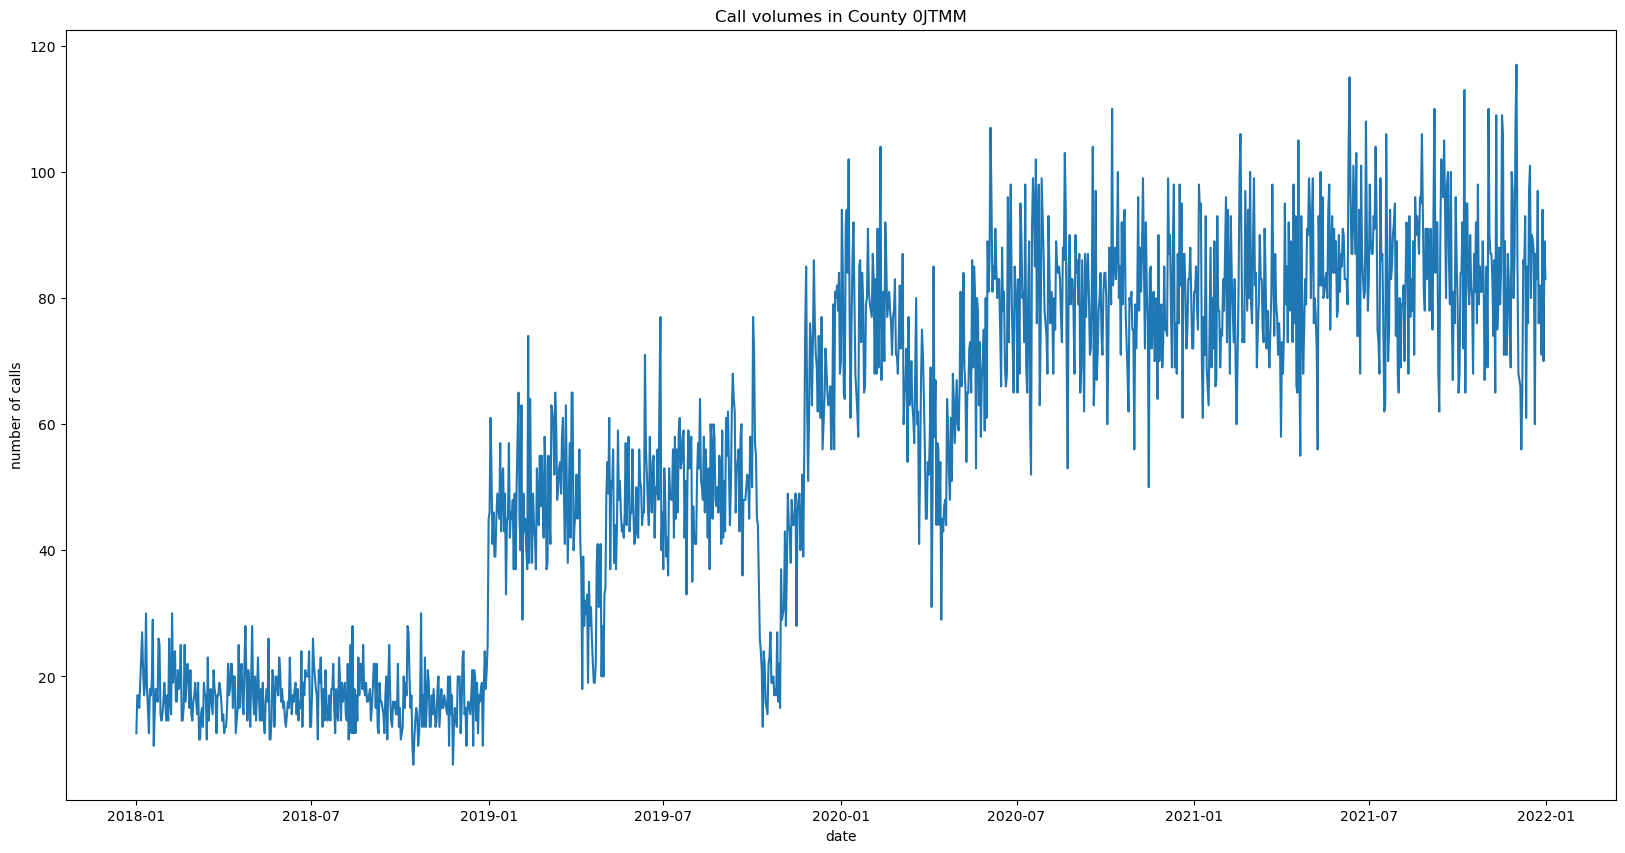

In [106]:
#Plot of the number of calls each day
plt.figure(figsize=(20,10))
plt.plot(data['date'], data['count'])
plt.title('Call volumes in County 0JTMM')
plt.xlabel('date')
plt.ylabel('number of calls')
plt.show()

### Observations about call volume
- The big jump from 2018 to 2019 suggests more data collection sites were added
- 2019 has a lot of instability for some reason
- The dip in early 2020 is likely due to the COVID lockdown period
- 2018, 2021 very stable overall

C:\Users\Karina\AppData\Local\Temp\ipykernel_22744\3296736943.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.666666666666664' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data2019.loc[i,'avgcount']=np.mean(data2019.loc[[i,i+1,i+2],'avgcount'])
C:\Users\Karina\AppData\Local\Temp\ipykernel_22744\3296736943.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '83.66666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data2021.loc[i,'avgcount']=np.mean(data2021.loc[[i,i+1,i+2],'avgcount'])
C:\Users\Karina\AppData\Local\Temp\ipykernel_22744\3296736943.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.333333333333332' has dtype incompatible 

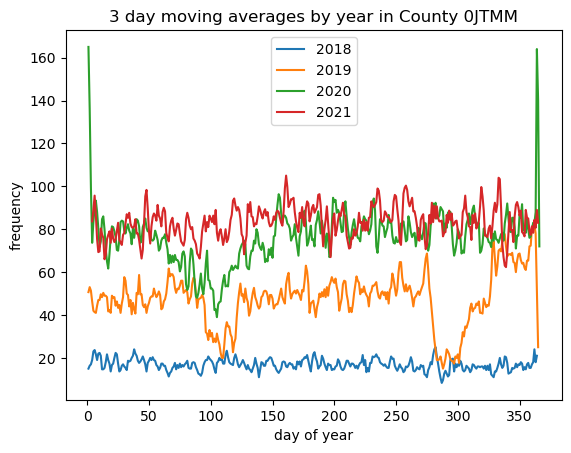

In [ ]:
#Stacking each year in one graph to identify potential yearly seasonality
#this code block was pair programmed with Jessica

from datetime import datetime
day_of_year = datetime.now().timetuple().tm_yday  # returns 1 for January 1st

df['Year']=df.DateTime.apply(lambda x: x.isocalendar().year)
df['Day']=df.DateTime.apply(lambda x: x.timetuple().tm_yday)

df2018= df[df['Year']==2018]
df2019= df[df['Year']==2019]
df2020= df[df['Year']==2020]
df2021= df[df['Year']==2021]

data2018=df2018.Day.value_counts().sort_index().reset_index().rename(columns={'index':'Value','Date':'date'})
data2019=df2019.Day.value_counts().sort_index().reset_index().rename(columns={'index':'Value','Date':'date'})
data2020=df2020.Day.value_counts().sort_index().reset_index().rename(columns={'index':'Value','Date':'date'})
data2021=df2021.Day.value_counts().sort_index().reset_index().rename(columns={'index':'Value','Date':'date'})

data2018['avgcount']=data2018['count']
data2019['avgcount']=data2019['count']
data2020['avgcount']=data2020['count']
data2021['avgcount']=data2021['count']

for i in range(360):
    data2018.loc[i,'avgcount']=np.mean(data2018.loc[[i,i+1,i+2],'avgcount']) #can change how many days to average here
    data2019.loc[i,'avgcount']=np.mean(data2019.loc[[i,i+1,i+2],'avgcount'])
    data2020.loc[i,'avgcount']=np.mean(data2020.loc[[i,i+1,i+2],'avgcount'])
    data2021.loc[i,'avgcount']=np.mean(data2021.loc[[i,i+1,i+2],'avgcount'])

#df_w=df.groupby(by='Year').Date.value_counts().unstack()
plt.plot(data2018['Day'], data2018['avgcount'],label=['2018'])
plt.plot(data2019['Day'], data2019['avgcount'],label=['2019'])
plt.plot(data2020['Day'], data2020['avgcount'],label=['2020'])
plt.plot(data2021['Day'], data2021['avgcount'],label=['2021'])
plt.legend()
plt.title('3 day moving averages by year in County 0JTMM')
plt.xlabel('day of year')
plt.ylabel('frequency')
plt.show()


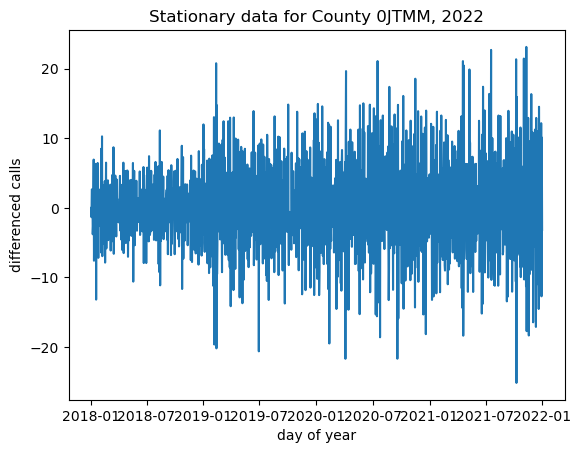

In [ ]:
from scipy.stats import boxcox

#make data stationary
data['calls_box_cox'], lam =boxcox(data['count']) #boxcox returns a tuple: transformed data set, lambda that maximizes log-likelihood
data['calls_diff']=data['calls_box_cox'].diff()
data.dropna(inplace=True)

#plot stationary data
plt.plot(data['date'], data['calls_diff'])
plt.title('Stationary data for County 0JTMM')
plt.xlabel('day of year')
plt.ylabel('differenced calls')
plt.show()

Note: Variance appears to increase over time, which should be addressed

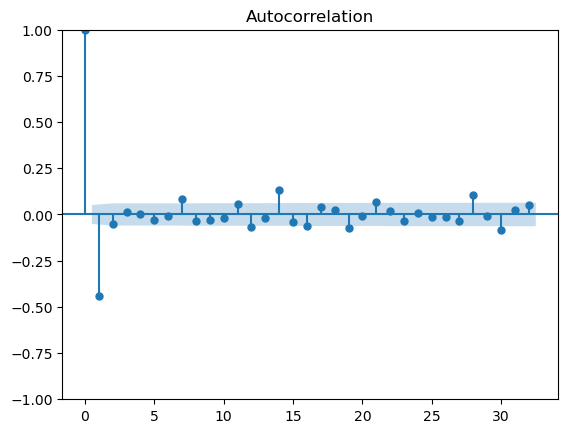

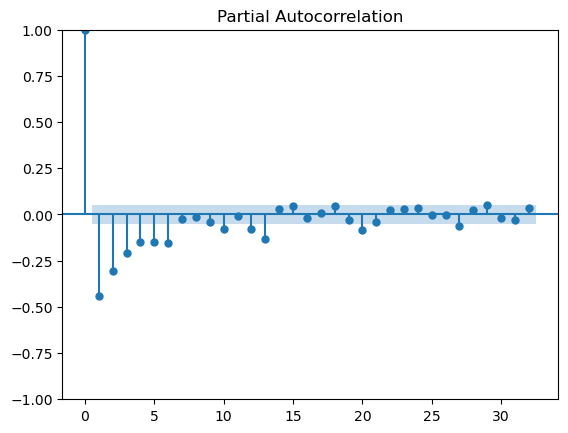

In [109]:
#Modelling
#(partial) autocorrelation plots
# autocorrelation: correlation between x_n and x_{n-i}
# partial ac: correlation between the linear combination of x_{n,n-1,...n-i+1} and x_{n-i}
# useful in finding parameters p and q
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=80)
plot_acf(data['calls_diff'])
plot_pacf(data['calls_diff'], method='ywm')
#ax1.tick_params(axis='both', labelsize=12)
#ax2.tick_params(axis='both', labelsize=12)
plt.show()

### Observations about autocorrelation
From ACF: looks like a seasonality of 7 or 14

From PACF: significant lags at 6 and 13
experiment by hand for values of p,q

(p,d,q)(P,D,Q)[m]
(6,0,?)(?,?,?)[7,14]

In [110]:
from pmdarima import auto_arima

auto_arima(data.calls_diff, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=9011.163, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9628.369, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9316.496, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9012.308, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9626.392, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=9009.212, Time=0.29 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=9007.259, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=9009.223, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=9007.389, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=9011.197, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9006.059, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9010.997, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=9008.002, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=9008.014, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]          

ARIMA(order=(0, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-package

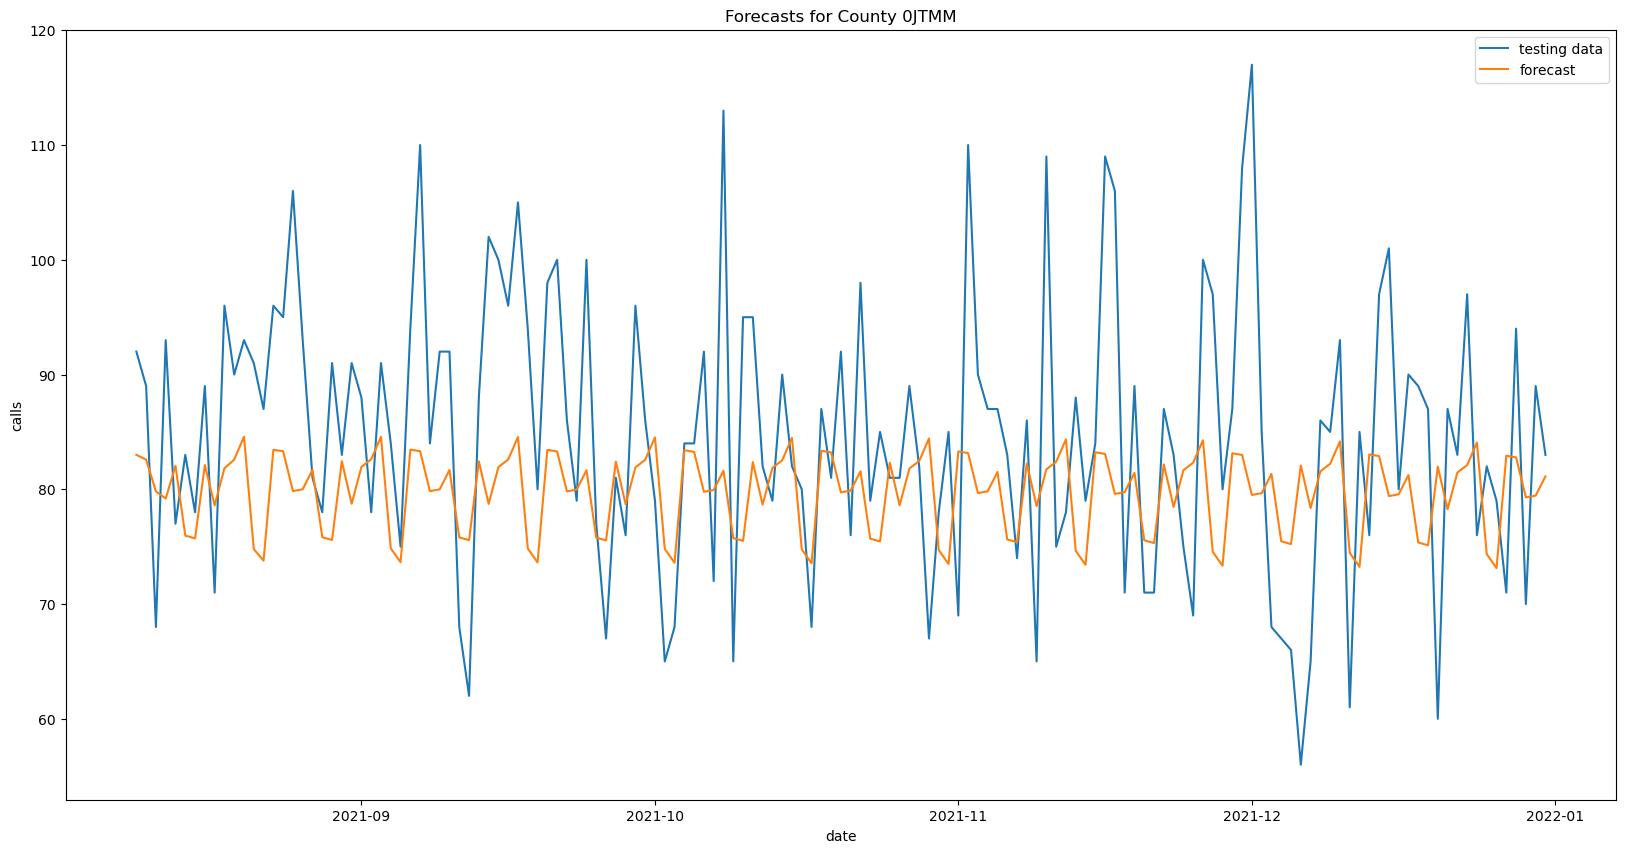

In [ ]:
import statsmodels.tsa.api as sm
from scipy.special import inv_boxcox

#train test split
train=data.iloc[:-int(len(data)*0.1)]
test=data.iloc[-int(len(data)*0.1):]

#ARIMA model
model=sm.ARIMA(train.calls_box_cox, order=(6,2,2), seasonal_order=(1,1,1,14)).fit() #messing with the parameters changes the model
boxcox_forecasts=model.forecast(len(test))
forecasts=inv_boxcox(boxcox_forecasts, lam) #undo the boxcox transform we did earlier

#plot forecasts

plt.figure(figsize=(20,10))
#plt.plot(train['date'], train['count'], label='training data') #train
plt.plot(test['date'], test['count'], label='testing data') #test
plt.plot(test['date'], forecasts, label='forecast') #forecast
plt.legend()
plt.title('Forecasts for County 0JTMM')
plt.xlabel('date')
plt.ylabel('calls')
plt.show()


## Model Comparison
We will compare some models using time series cross validation
- Model 0: baseline naive forecast
- Model 1: `auto_arima` output
- Model 2: custom SARIMA model with parameters suggested by (P)ACF analysis
- Model 3: another custom SARIMA model with different sensible parameters

Cross validation scheme:
- forecast horizon of 21 days
- reserve last 10% of data as testing set, so do not look at it during CV
- 10 fold cross validation
    - Fold 1: Train on [:-210], predict [-210:-210-21]
    - $\vdots$
    - Fold 10: Train on [:-21], predict [-21:]

In [145]:
from sklearn.linear_model import LinearRegression

In [168]:
model0_preds = [] #naive
model1_preds = [] #auto arima
model2_preds = [] #custom sarima 
model3_preds = [] #custom sarima alt

for i in range(-10,0):
    y_tt = train['calls_box_cox'].values[:(21*i)]
    y_ho = train['calls_box_cox'].values[(21*i):(21*(i+1))]

    model1=auto_arima(y_tt)
    model2=sm.ARIMA(y_tt, order=(6,2,2), seasonal_order=(1,1,1,14)).fit()
    model3=sm.ARIMA(y_tt, order=(6,2,2), seasonal_order=(1,1,1,7)).fit()

    model0_preds.append(inv_boxcox(y_tt[-1]*np.ones(21),lam))

    model1_preds.append(inv_boxcox(model1.predict(21),lam)) #use predict for autoarima
    

    model2_preds.append(inv_boxcox(model2.forecast(21),lam)) #use forecast for statsmodel
    

    model3_preds.append(inv_boxcox(model3.forecast(21),lam))

c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fo

In [173]:
len(np.concatenate(model2_preds))


210

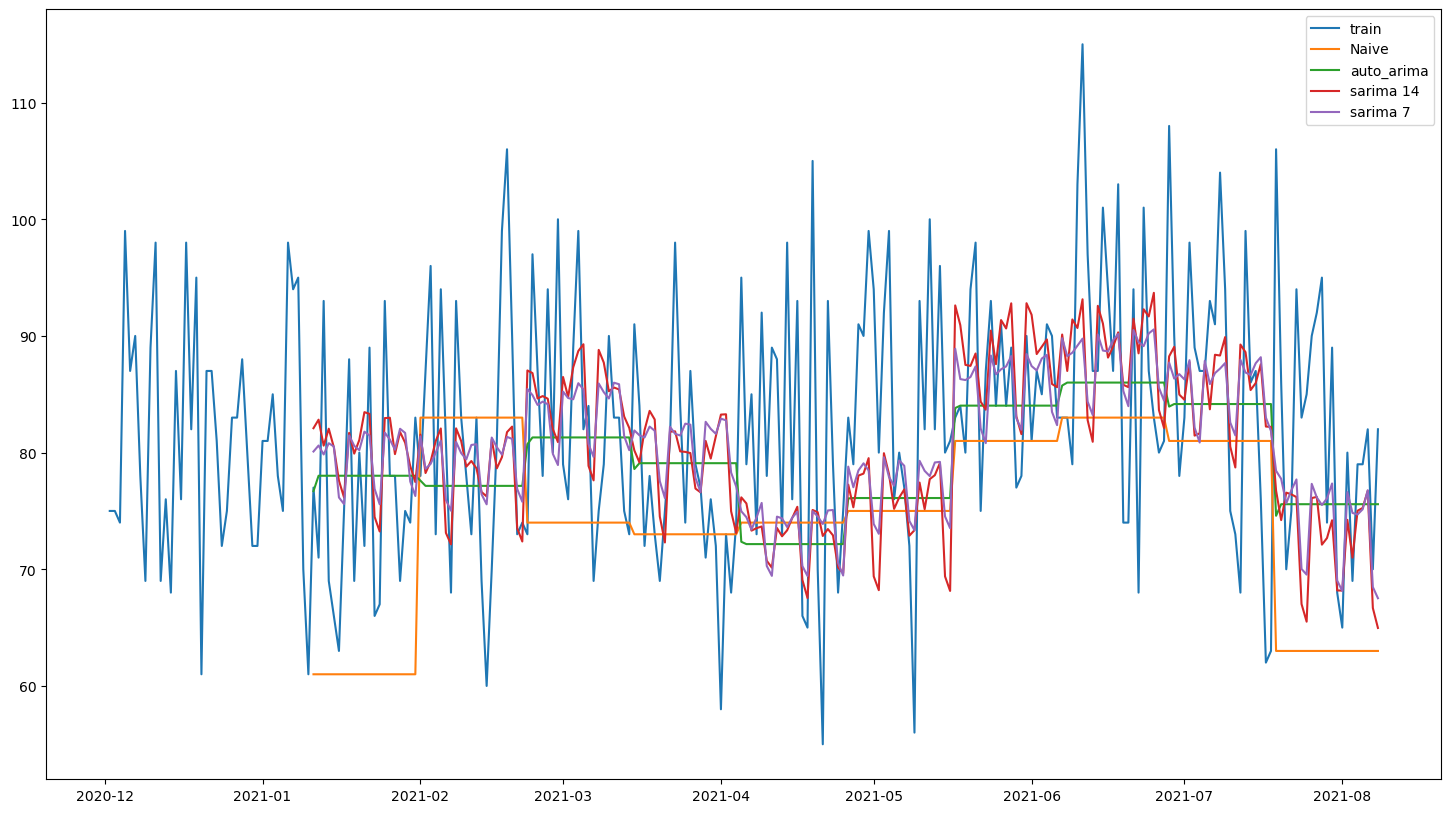

In [182]:
#adjust
plt.figure(figsize=(18,10))
plt.plot(train['date'][-250:], train['count'][-250:], label='train')
plt.plot(train['date'][-210:], np.concatenate(model0_preds), label = 'Naive')
plt.plot(train['date'][-210:], np.concatenate(model1_preds), label = 'auto_arima')
plt.plot(train['date'][-210:], np.concatenate(model2_preds), label = 'sarima 14')
plt.plot(train['date'][-210:], np.concatenate(model3_preds), label = 'sarima 7')
plt.legend()
plt.show()

In [179]:
from sklearn.metrics import mean_squared_error as mse

mse0 = mse(train['count'][-210:],np.concatenate(model0_preds))
mse1 = mse(train['count'][-210:],np.concatenate(model1_preds))
mse2 = mse(train['count'][-210:],np.concatenate(model2_preds))
mse3 = mse(train['count'][-210:],np.concatenate(model3_preds))

unordered_dict = {'Model 0':mse0, 'Model 1':mse1, 'Model 2':mse2, 'Model 3':mse3}
ordered_dict = dict(sorted(unordered_dict.items(), key=lambda item: item[1], reverse=True))
ordered_dict

{'Model 0': np.float64(192.34761904761893),
 'Model 1': np.float64(126.9242386482724),
 'Model 2': np.float64(116.5480168779241),
 'Model 3': np.float64(110.91693829300621)}

The best performing model was the SARIMA (6,2,2)(1,1,1,7). You can fiddle further with the parameters to see if you can get a smaller MSE, but the runtime is long (~5 mins)